updated 06/25/2021 with removing GDSD0 and GDSD3

In [2]:
library(pheatmap)  
library(tidyverse)
library(RColorBrewer)
library(viridis)
library(reshape2)
library( org.Hs.eg.db ) 
library(AnnotationDbi) 
library(Biobase)
library(limma)
library(tximport)

library(stringr)
library(GenomicRanges)
library(ChIPseeker)
library(TxDb.Hsapiens.UCSC.hg19.knownGene)


library(Rtsne)
library(caret)  
library(clusterProfiler)
library(pheatmap)
library(ReactomePA)
library(annotate)
library(seqinr)
# library(qlcMatrix)


In [3]:
save_pheatmap_png <- function(x, filename, width=1200, height=1000, res = 200) {
  png(filename, width = width, height = height, res = res)
  grid::grid.newpage()
  grid::grid.draw(x$gtable)
  dev.off()
}
save_pheatmap_pdf <- function(x, filename, width=7, height=7) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   pdf(filename, width=width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

In [4]:

createSig <- function (data, metadata, col_sel,tissue=TRUE, logFC_thres=.1, p_thres=0.05,max_return = -1) {
    # Differential expression analysis with limmma
    # This function takes in a target
    # Output is a result table of differential expression analysis for target vs control

    # load data and preprocess
    if (tissue){
    metadata = metadata %>% 
        mutate(label = if_else(tissues==col_sel, 'target', 'control'))
    }
    else{
         metadata = metadata %>% 
        mutate(label = if_else(group==col_sel, 'target', 'control'))
    }

    # set up the design
    labels <- factor(metadata$label)
    design <- model.matrix(~ labels + 1)
    colnames(design) <- levels(labels)
    rownames(design) <- metadata$tissue

    # proceed with analysis
    fit <- lmFit(data, design)
    fit <- eBayes(fit, trend=TRUE)
    tT = topTable(fit, coef=ncol(design),adjust="fdr", sort.by="p", number=Inf)
    tT$gene = rownames(tT)
    tT = na.omit(tT)
    tT_filt = tT[tT$logFC>logFC_thres  & tT$adj.P.Val<p_thres,]
    tT_filt = tT_filt%>% arrange(adj.P.Val)%>% arrange(desc(logFC))
    print(dim(tT_filt))
    if( max_return >0){
        tT_filt = tT_filt[1:min(max_return, dim(tT_filt)[1]),]
    }
  return(tT_filt)
}

In [5]:
save_prefix = '../data/processed/fig1/hichip/'

In [6]:
tissue_loop_df = read.csv(paste0(save_prefix,'tissue_loop_df.csv'),row.names=1)

In [7]:
tissue_loop_df_log = log2(tissue_loop_df+1e-2)
tissue_loop_df_norm = as.data.frame(scale(tissue_loop_df_log, center = TRUE, scale = TRUE))


In [8]:
normal_tissue_order = c('GM12878',
                        'Astrocytes', 'Melanocytes',
                         'Colon',  'Esophageal','Ovarian', 'Pancreas','Renal','Thyroid',
                        'Airway','Bladder','GDSD6','HMEC','Prostate','Uterine')

annon_df = read.csv( '../data/processed/fig1/rna/annon_df.csv')
annon_df = annon_df %>%
    filter(X %in% normal_tissue_order)%>%
    column_to_rownames('X')

In [9]:
dim(tissue_loop_df)
head(tissue_loop_df)

[1] 1092981      15

,Airway,Astrocytes,Bladder,Colon,Esophageal,GDSD6,GM12878,HMEC,Melanocytes,Ovarian,Pancreas,Prostate,Renal,Thyroid,Uterine
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
chr10_100020000_100025000::chr10_100055000_100060000,13,0,0,0,0,0,0,14,0,0,0,0,0,0,0
chr10_100020000_100025000::chr10_100065000_100070000,13,17,0,2825,2421,16,0,1315,0,1523,1619,21,2021,2423,33
chr10_100025000_100030000::chr10_100055000_100060000,14,0,0,0,2516,0,0,0,0,18,23,0,16,0,0
chr10_100025000_100030000::chr10_100065000_100070000,11,22,0,2622,3336,18,0,0,0,4221,3350,1816,1937,2435,0
chr10_101150000_101155000::chr10_101180000_101185000,14,0,0,0,0,0,0,0,0,0,0,0,0,19,0
chr10_101150000_101155000::chr10_101190000_101195000,1529,26,20,4931,3031,0,0,27,0,4244,2624,2464,2932,3740,6627


In [10]:
metadata = annon_df
metadata$tissue = rownames(annon_df)
metadata$group = as.character(metadata$group)

metadata['Astrocytes','group'] = 'blue1'
metadata['Melanocytes','group'] = 'blue2'
metadata$group = as.factor(metadata$group)
metadata

,group,tissue
,<fct>,<chr>
Airway,purple,Airway
Astrocytes,blue1,Astrocytes
Bladder,purple,Bladder
Colon,green,Colon
Esophageal,green,Esophageal
GDSD6,purple,GDSD6
GM12878,grey,GM12878
HMEC,purple,HMEC
Melanocytes,blue2,Melanocytes


In [11]:
#### per group


sig_loop_list = list()
sig_loop_combined = c()
for (group in c("grey","blue1", 'blue2', "green","purple")){
    tT_filt = createSig(tissue_loop_df_log, metadata,  col_sel=group,tissue=FALSE,max_return = 10000)
    print(group)
    print(dim(tT_filt))
    sig_loop_list[[group]] = tT_filt$gene
    sig_loop_combined = c(sig_loop_combined,tT_filt$gene)
}

[1] 98756     7
[1] "grey"
[1] 10000     7


Warning message:
“Zero sample variances detected, have been offset away from zero”


[1] 63992     7
[1] "blue1"
[1] 10000     7
[1] 17746     7
[1] "blue2"
[1] 10000     7
[1] 18058     7
[1] "green"
[1] 10000     7
[1] 6543    7
[1] "purple"
[1] 6543    7


In [12]:
length(sig_loop_combined)
# sig_genes_combined = unique(sort(sig_genes_combined))
sig_loop_combined = unique(sig_loop_combined)
length(sig_loop_combined)

[1] 46543

[1] 46543

In [13]:
tissue_loop_sig = tissue_loop_df_norm[sig_loop_combined,normal_tissue_order]
# rna_df_tissue_norm_sig = rna_df_tissue_norm[sig_genes_sel,normal_tissue_order]
dim(tissue_loop_sig)
tissue_loop_sig[tissue_loop_sig>3] = 3
tissue_loop_sig[tissue_loop_sig< -3] = -3
tissue_loop_sig = tissue_loop_sig[apply(tissue_loop_sig,1,max)>0 ,]
# tissue_loop_sig = tissue_loop_sig[apply(tissue_loop_sig,1,sum)< 7,]
tissue_loop_sig = tissue_loop_sig[apply(tissue_loop_sig,1,sd)>0.2 ,]
select_loops = rownames(tissue_loop_sig)
dim(tissue_loop_sig)

[1] 46543    15

[1] 46540    15

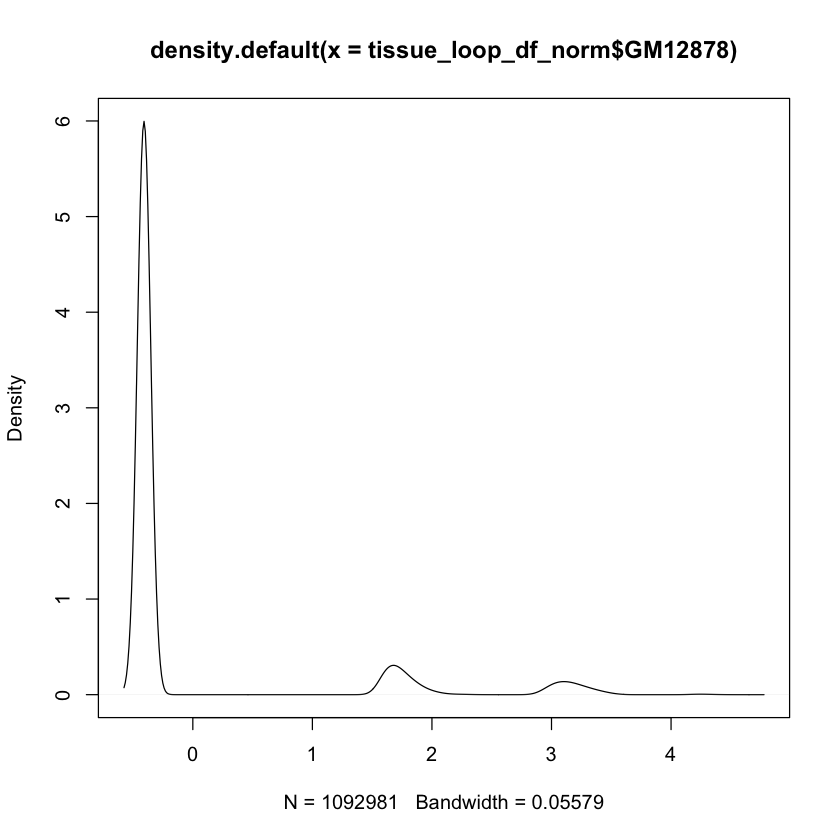

In [14]:
par (bg='white')
plot(density(tissue_loop_df_norm$"GM12878"))

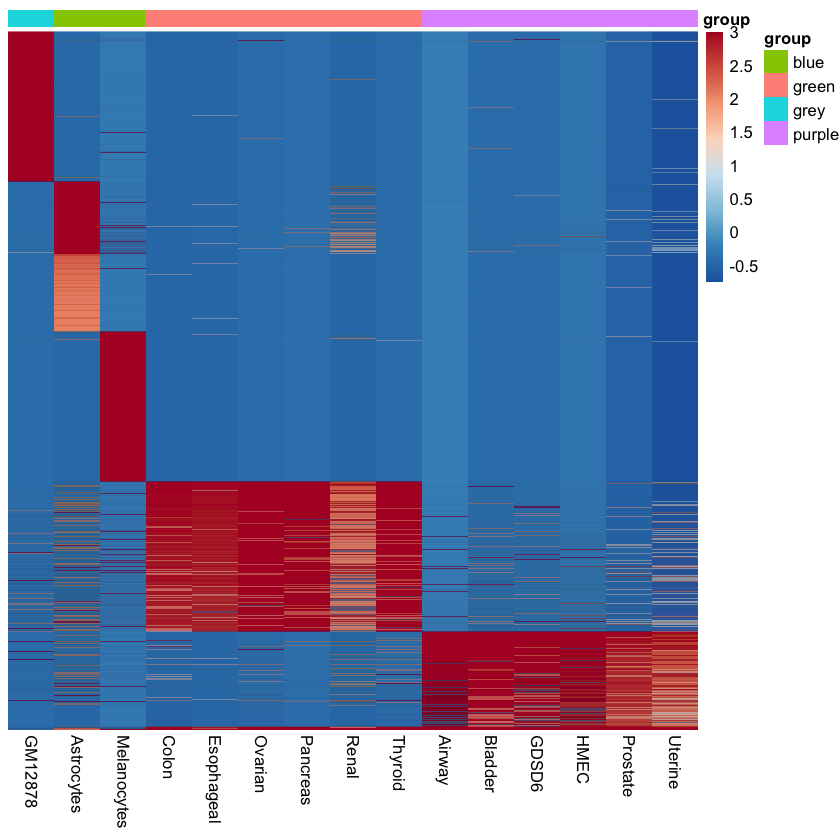

In [15]:
p_10000 = pheatmap(tissue_loop_sig,
             cluster_rows=F,
             cluster_cols=F,
                show_rownames=F,
             annotation_col=annon_df,
               color = colorRampPalette(rev(brewer.pal(n =8, name ="RdBu")))(255))


In [30]:
save_pheatmap_pdf( p_10000, paste0(save_prefix, 'heatmap_top10000.pdf'), height=8, width=8)

pdf 
  2

# getting gene signatures

In [18]:
purple_loops= sig_loop_list$purple[ sig_loop_list$purple %in% select_loops]
length(purple_loops)
green_loops = sig_loop_list$green[ sig_loop_list$green %in% select_loops]
length(green_loops)
blue1_loops  = sig_loop_list$blue1[ sig_loop_list$blue1 %in% select_loops]
length(blue1_loops)
blue2_loops  = sig_loop_list$blue2[ sig_loop_list$blue2 %in% select_loops]
length(blue2_loops)
grey_loops  = sig_loop_list$grey[ sig_loop_list$grey %in% select_loops]
length(grey_loops)
all_loops = rownames(tissue_loop_df_norm)
length(all_loops)

[1] 6540

[1] 10000

[1] 10000

[1] 10000

[1] 10000

[1] 1092981

In [20]:
get_genes = function(loops){
    df = data.frame("loop"=loops)%>%
        separate(loop, c('source','target'), sep='::')
    df_anc <- data.frame("anchor" = unique(c(df[,"source"], df[,"target"]))) %>%
        separate(anchor, c("chr", "start", "stop"), sep='_')
    df_gr = makeGRangesFromDataFrame(df_anc)#                         seqnames.field=c("seqnames", "seqname",
    df_gr_anno = annotatePeak(df_gr, TxDb = TxDb.Hsapiens.UCSC.hg19.knownGene)

    df_gr_anno <- as.data.frame(df_gr_anno)
    df_gr_anno$symbol <- mapIds(org.Hs.eg.db, keys=df_gr_anno$geneId, column="SYMBOL", keytype="ENTREZID", multiVals="first")

    genes = unique(df_gr_anno$symbol)
    return(genes)
}

In [21]:
purple_genes= get_genes(purple_loops)
length(purple_genes)
green_genes = get_genes(green_loops)
length(green_genes)
blue1_genes  = get_genes(blue1_loops)
length(blue1_genes)
blue2_genes  = get_genes(blue2_loops)
length(blue2_genes)
grey_genes  = get_genes(grey_loops)
length(grey_genes)

>> preparing features information...		 2021-07-07 14:55:47 
>> identifying nearest features...		 2021-07-07 14:55:47 
>> calculating distance from peak to TSS...	 2021-07-07 14:55:48 
>> assigning genomic annotation...		 2021-07-07 14:55:48 
>> assigning chromosome lengths			 2021-07-07 14:56:01 
>> done...					 2021-07-07 14:56:01 


'select()' returned 1:1 mapping between keys and columns



[1] 2118

>> preparing features information...		 2021-07-07 14:56:02 
>> identifying nearest features...		 2021-07-07 14:56:02 
>> calculating distance from peak to TSS...	 2021-07-07 14:56:02 
>> assigning genomic annotation...		 2021-07-07 14:56:02 
>> assigning chromosome lengths			 2021-07-07 14:56:04 
>> done...					 2021-07-07 14:56:04 


'select()' returned 1:1 mapping between keys and columns



[1] 3793

>> preparing features information...		 2021-07-07 14:56:04 
>> identifying nearest features...		 2021-07-07 14:56:04 
>> calculating distance from peak to TSS...	 2021-07-07 14:56:05 
>> assigning genomic annotation...		 2021-07-07 14:56:05 
>> assigning chromosome lengths			 2021-07-07 14:56:06 
>> done...					 2021-07-07 14:56:06 


'select()' returned 1:1 mapping between keys and columns



[1] 3347

>> preparing features information...		 2021-07-07 14:56:07 
>> identifying nearest features...		 2021-07-07 14:56:07 
>> calculating distance from peak to TSS...	 2021-07-07 14:56:07 
>> assigning genomic annotation...		 2021-07-07 14:56:07 
>> assigning chromosome lengths			 2021-07-07 14:56:09 
>> done...					 2021-07-07 14:56:09 


'select()' returned 1:1 mapping between keys and columns



[1] 4976

>> preparing features information...		 2021-07-07 14:56:09 
>> identifying nearest features...		 2021-07-07 14:56:09 
>> calculating distance from peak to TSS...	 2021-07-07 14:56:10 
>> assigning genomic annotation...		 2021-07-07 14:56:10 
>> assigning chromosome lengths			 2021-07-07 14:56:12 
>> done...					 2021-07-07 14:56:12 


'select()' returned 1:1 mapping between keys and columns



[1] 2695

In [22]:
write.table(sort(purple_genes), file = paste0(save_prefix, "purple_genes.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(green_genes), file = paste0(save_prefix, "green_genes.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(blue1_genes), file = paste0(save_prefix, "blue1_genes.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(blue2_genes), file = paste0(save_prefix, "blue2_genes.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(grey_genes), file = paste0(save_prefix, "grey_genes.csv"),row.names=FALSE,col.names=FALSE)
# write.table(sort(all_genes), file = paste0(save_prefix, "all_genes.csv"),row.names=FALSE,col.names=FALSE)


In [24]:
# library(VennDiagram)
 
# # Chart
# venn.diagram(
#     x = list("purple"=purple_genes, "green"=green_genes, "blue1"=blue1_genes,"blue2"=blue2_genes, "grey"=grey_genes),
#   filename = paste0(save_prefix,'venn_diagram.png'),
# #   output=TRUE
#  # Output features
#     imagetype="png" ,
# #     height = 40 , 
# #     width = 40 , 
# #     resolution = 200,
# #     compression = "lzw",

# #     # Circles
# #     lwd = 2,
# #     lty = 'blank',
#     fill = c("purple","green", "lightblue","blue", "grey"),
        
# )


## gene signature checking

In [26]:
purple_genes = read.table(file = paste0(save_prefix, "purple_genes.csv"))$V1
green_genes = read.table(file = paste0(save_prefix, "green_genes.csv"))$V1
blue1_genes = read.table(file = paste0(save_prefix, "blue1_genes.csv"))$V1
blue2_genes = read.table(file = paste0(save_prefix, "blue2_genes.csv"))$V1
grey_genes = read.table(file = paste0(save_prefix, "grey_genes.csv"))$V1


library(VennDiagram)  
overlap = calculate.overlap(
  x = list("purple"=purple_genes, "green"=green_genes, "blue1"=blue1_genes,"blue2"=blue2_genes, "grey"=grey_genes))
purple_only = overlap[[31]]
blue1_only = overlap[[29]]
blue2_only = overlap[[28]]
green_only = overlap[[30]]
grey_only = overlap[[27]]

In [27]:
for (x in overlap){
    print(length(x))
}

[1] 49
[1] 118
[1] 19
[1] 12
[1] 58
[1] 87
[1] 100
[1] 260
[1] 160
[1] 77
[1] 65
[1] 28
[1] 74
[1] 72
[1] 42
[1] 128
[1] 405
[1] 488
[1] 640
[1] 199
[1] 298
[1] 248
[1] 135
[1] 249
[1] 103
[1] 164
[1] 1114
[1] 2075
[1] 982
[1] 1734
[1] 722


In [28]:
write.table(sort(purple_only), file = paste0(save_prefix, "purple_only.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(blue1_only), file = paste0(save_prefix, "blue1_only.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(blue2_only), file = paste0(save_prefix, "blue2_only.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(green_only), file = paste0(save_prefix, "green_only.csv"),row.names=FALSE,col.names=FALSE)
write.table(sort(grey_only), file = paste0(save_prefix, "grey_only.csv"),row.names=FALSE,col.names=FALSE)


In [29]:
# # length(purple_genes[!(purple_genes %in% c(green_genes, blue_genes, grey_genes))])
# length(blue1_genes[!(blue1_genes %in% c(purple_genes, green_genes, blue2_genes,grey_genes))])

In [30]:
purple_entrez = bitr(purple_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
green_entrez = bitr(green_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
blue1_entrez = bitr(blue1_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
blue2_entrez = bitr(blue2_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID
grey_entrez = bitr(grey_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID

# all_entrez = bitr(all_genes, fromType="SYMBOL", toType="ENTREZID", OrgDb="org.Hs.eg.db")$ENTREZID


'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:1 mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



In [31]:
length(purple_entrez)
length(green_entrez)
length(blue1_entrez)
length(blue2_entrez)
length(grey_entrez)
# length(all_entrez)

[1] 2117

[1] 3793

[1] 3346

[1] 4975

[1] 2695

In [32]:
cluster_all <- list(purple = purple_entrez, 
                       green = green_entrez,
                      blue1 = blue1_entrez,
                      blue2 = blue2_entrez,
                      grey = grey_entrez)

In [33]:
ck_reactome_90 <- compareCluster(geneCluster = cluster_all, 
                                 fun = "enrichPathway", pAdjustMethod='none', pvalueCutoff = 1,readable=TRUE)
write.csv(ck_reactome_90, file = paste0(save_prefix, "ck_reactome_groups.csv"))

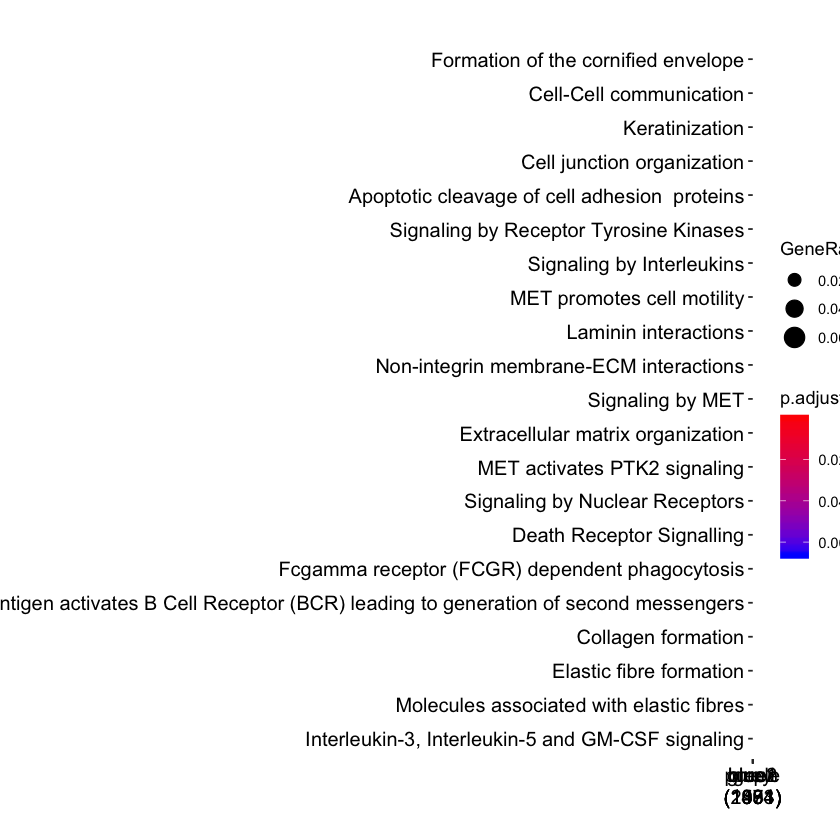

In [34]:
dotplot(ck_reactome_90)
ggsave(file = paste0(save_prefix, "ck_reactome_groups.pdf"),height=7, width=10)

In [35]:
ck_go_bp <- compareCluster(geneCluster = cluster_all, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 0.05,
                                qvalueCutoff  = 0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "BP",
                                readable=TRUE)
head(as.data.frame(ck_go_bp))
write.csv(ck_go_bp, file=paste0(save_prefix, 'ck_go_bp_05.csv'))

ck_go_mf <- compareCluster(geneCluster = cluster_all, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 0.05,
                                qvalueCutoff  = 0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "MF",
                                readable=TRUE)                              
head(as.data.frame(ck_go_mf))
write.csv(ck_go_mf, file=paste0(save_prefix, 'ck_go_mf_05.csv'))


ck_go_cc <- compareCluster(geneCluster = cluster_all, fun = "enrichGO", 
                                pAdjustMethod='BH', 
                                pvalueCutoff  = 0.05,
                                qvalueCutoff  = 0.05,
                                OrgDb='org.Hs.eg.db', 
                                ont = "CC",
                                readable=TRUE)
head(as.data.frame(ck_go_cc))
write.csv(ck_go_cc, file=paste0(save_prefix, 'ck_go_cc_05.csv'))

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,purple,GO:0008544,epidermis development,107/1679,464/18670,2.914973e-20,1.753939e-16,1.390596e-16,ABCA12/ANXA1/ATP2A2/BCL2/CALML5/CD109/CDH3/CELSR1/COL17A1/COL7A1/CSTA/CTNNB1/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FGFR2/FOSL2/FOXC1/FST/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KRT14/KRT15/KRT16/KRT20/KRT23/KRT31/KRT32/KRT33A/KRT34/KRT37/KRT39/KRT5/KRT6A/KRT74/KRT78/KRT8/KRT80/KRT83/KRT84/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP29-1/KRTAP3-2/KRTAP4-6/KRTAP4-8/LAMA3/LAMB3/LAMC2/LCE5A/LELP1/LGR4/MYSM1/NAB2/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PITX2/PKP1/POU2F3/PPARD/PRKCH/PTHLH/RBP2/RPTN/RUNX1/SATB1/SERPINB13/SOS1/SOX9/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TMC1/TNFRSF19/TP63/TRIOBP/UGCG/YAP1/ZFP36L1/ZNF750,107
2,purple,GO:0034330,cell junction organization,76/1679,290/18670,4.889421e-18,1.470982e-14,1.166256e-14,ACTN4/AFDN/ANK2/ARHGEF7/ARVCF/BCL2/BMP6/CAV1/CD9/CDH1/CDH17/CDH26/CDH3/CLASP1/CLDN1/COL17A1/CORO1C/CTNNB1/CTNND1/DLC1/DSG1/DSG2/DSP/DST/EFNA5/F11R/F2R/F2RL1/FBLIM1/FN1/FSCN1/GJB2/GRHL1/GRHL2/ITGA2/ITGA6/JUP/KRT14/KRT5/LAMA3/LAMB3/LAMC2/LRP1/LSR/MACF1/MAP4K4/MPP7/NECTIN1/NECTIN4/NRP1/PARD3/PARD6G/PERP/PHLDB2/PKP1/PLEKHA7/POF1B/PRKCH/PTPRK/PTPRO/RAB8B/RAPGEF1/RCC2/RHOC/RUNX1/S100A10/SLK/SMAD7/SNAI2/SRC/TBCD/TGFBR1/THBS1/TRPV4/VMP1/WDR1,76
3,purple,GO:0043588,skin development,93/1679,419/18670,1.279040e-16,2.565327e-13,2.033897e-13,ABCA12/ANXA1/BCL2/CD109/CDH3/CELSR1/CLDN1/CLDN4/CSTA/CTNNB1/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FGFR2/FOSL2/FOXC1/FST/GJB3/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/ITGA2/ITGA6/IVL/JAG1/JUP/KAZN/KRT14/KRT15/KRT16/KRT20/KRT23/KRT31/KRT32/KRT33A/KRT34/KRT37/KRT39/KRT5/KRT6A/KRT74/KRT78/KRT8/KRT80/KRT83/KRT84/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP29-1/KRTAP3-2/KRTAP4-6/KRTAP4-8/LCE5A/LELP1/LGR4/MET/MYSM1/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SOS1/SOX9/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/STMN1/TNFRSF19/TP63/UGCG/YAP1/ZFP36L1,93
4,purple,GO:0034329,cell junction assembly,64/1679,241/18670,1.067231e-15,1.605382e-12,1.272813e-12,ACTN4/AFDN/ANK2/ARHGEF7/ARVCF/BCL2/CAV1/CD9/CDH1/CDH17/CDH26/CDH3/CLASP1/CLDN1/COL17A1/CORO1C/CTNNB1/CTNND1/DLC1/DSG1/DST/EFNA5/F11R/FBLIM1/FN1/FSCN1/GJB2/GRHL2/ITGA2/ITGA6/JUP/KRT14/KRT5/LAMA3/LAMB3/LAMC2/LRP1/LSR/MACF1/MAP4K4/MPP7/NRP1/PARD3/PARD6G/PHLDB2/PKP1/POF1B/PRKCH/PTPRK/PTPRO/RAPGEF1/RCC2/RHOC/RUNX1/S100A10/SLK/SMAD7/SNAI2/SRC/TBCD/THBS1/TRPV4/VMP1/WDR1,64
5,purple,GO:0009913,epidermal cell differentiation,80/1679,358/18670,1.215253e-14,1.391167e-11,1.102975e-11,ABCA12/ANXA1/CD109/CDH3/CSTA/CTNNB1/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/FOXC1/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KRT14/KRT15/KRT16/KRT20/KRT23/KRT31/KRT32/KRT33A/KRT34/KRT37/KRT39/KRT5/KRT6A/KRT74/KRT78/KRT8/KRT80/KRT83/KRT84/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP29-1/KRTAP3-2/KRTAP4-6/KRTAP4-8/LCE5A/LELP1/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PITX2/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TMC1/TP63/TRIOBP/UGCG/YAP1/ZFP36L1,80
6,purple,GO:0030216,keratinocyte differentiation,72/1679,305/18670,1.387236e-14,1.391167e-11,1.102975e-11,ABCA12/ANXA1/CD109/CDH3/CSTA/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/FOXC1/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KRT14/KRT15/KRT16/KRT20/KRT23/KRT31/KRT32/KRT33A/KRT34/KRT37/KRT39/KRT5/KRT6A/KRT74/KRT78/KRT8/KRT80/KRT83/KRT84/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP29-1/KRTAP3-2/KRTAP4-6/KRTAP4-8/LCE5A/LELP1/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TP63/UGCG/YAP1/ZFP36L1,72


,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,purple,GO:0050839,cell adhesion molecule binding,94/1627,499/17697,1.031346e-11,1.082913e-08,1.004205e-08,ABI1/ACTN4/ADAMTS8/AFDN/ANXA1/ANXA2/ARHGAP18/ARVCF/ATIC/BAG3/BAIAP2/CCN6/CD9/CDC42EP1/CDH1/CDH17/CDH26/CDH3/CDK5R1/CHMP5/CLINT1/COBLL1/CRKL/CTNNB1/CTNND1/DNAJB1/DOCK9/DSG2/DSP/DST/EGFR/EPN2/ERC1/F11R/FN1/FSCN1/FXYD5/GIPC1/GLOD4/HDLBP/HMCN1/IL1B/ITGA2/ITGA6/ITGB1/ITGB6/JAML/JUP/KIF5B/LAMA3/LYN/MACF1/MAPRE1/MPP7/MYO1B/NDRG1/NECTIN1/NECTIN4/NOTCH3/NPNT/NRG1/NRXN1/PHLDB2/PKM/PKP1/PPFIBP1/PSMB6/PTPN1/PTPRO/PTPRZ1/RPL14/RPL29/S100A11/SEMA7A/SEPTIN2/SERBP1/SLC14A2/SLK/SNX9/SPTBN1/SRC/STK24/SYK/TACSTD2/TENM2/TES/TGFBI/THBS1/TJP2/TMOD3/TNKS1BP1/TRIM29/UBAP2/YWHAZ,94
2,purple,GO:0045296,cadherin binding,67/1627,331/17697,4.562132e-10,2.395119e-07,2.221038e-07,ABI1/AFDN/ANXA1/ANXA2/ARHGAP18/ARVCF/ATIC/BAG3/BAIAP2/CDC42EP1/CDH1/CDH17/CDH26/CDH3/CDK5R1/CHMP5/CLINT1/COBLL1/CRKL/CTNNB1/CTNND1/DNAJB1/DOCK9/EGFR/EPN2/ERC1/F11R/FSCN1/FXYD5/GIPC1/GLOD4/HDLBP/ITGA6/ITGB1/JUP/KIF5B/MACF1/MAPRE1/MPP7/MYO1B/NDRG1/NOTCH3/PHLDB2/PKM/PKP1/PPFIBP1/PSMB6/PTPN1/PTPRO/RPL14/RPL29/S100A11/SEPTIN2/SERBP1/SLK/SNX9/SPTBN1/SRC/STK24/TACSTD2/TES/TJP2/TMOD3/TNKS1BP1/TRIM29/UBAP2/YWHAZ,67
3,purple,GO:0005088,Ras guanyl-nucleotide exchange factor activity,33/1627,137/17697,1.928782e-07,6.750738e-05,6.260083e-05,ADRB1/AKAP13/ARHGEF10/ARHGEF10L/ARHGEF28/ARHGEF3/ARHGEF37/ARHGEF4/ARHGEF7/C9orf72/DENND1B/DENND2C/DENND6A/ECT2L/FGD2/FGD4/FGD6/ITSN1/MCF2L2/NET1/PLEKHG3/PLEKHG5/PLEKHG6/RAB3GAP2/RAPGEF1/RAPGEF3/RAPGEF4/RAPGEF5/RASGEF1B/RCBTB2/RIN2/SBF2/SOS1,33
4,purple,GO:0003779,actin binding,72/1627,431/17697,4.297214e-07,1.128019e-04,1.046032e-04,ABLIM1/ACTN4/ACTR3/AFDN/ARPC1A/CAP1/CAPZA2/CDK5R1/COBLL1/CORO1C/CORO6/DIXDC1/DMD/DST/EGFR/EVL/FBXO25/FGD4/FHOD1/FKBP15/FMNL3/FSCN1/FXYD5/GIPC1/GSN/IQGAP2/ITGB1/ITPRID2/JMY/KCNMA1/KLHL2/MACF1/MARCKS/MICAL2/MRTFA/MTSS1/MYO10/MYO16/MYO1B/MYO1E/MYO3B/MYO5B/MYOM3/MYOZ2/NOD2/PALLD/PANX1/PAWR/POF1B/SHROOM3/SHROOM4/SLC6A2/SMTN/SPIRE1/SPTBN1/SSH1/SSH2/STK38L/SVIL/SYNE2/SYNPO2/TMOD3/TNS4/TPM1/TRIOBP/TRPC6/TRPV4/WASF1/WASL/WDR1/YWHAH/ZNF185,72
5,purple,GO:0001228,"DNA-binding transcription activator activity, RNA polymerase II-specific",71/1627,439/17697,1.756221e-06,3.688065e-04,3.420010e-04,ARID3B/ATF3/BACH1/BARX2/CEBPA/CEBPD/CEBPG/CLOCK/CREB1/DLX2/EBF2/ELK3/EPAS1/ERG/ESRRB/ETS1/FOSL2/FOXA1/FOXC1/GATA3/GLI3/GRHL1/GRHL2/GRHL3/HIF1A/HMGA2/IRF2/IRF2BP2/IRF5/IRF6/KLF10/KLF13/KLF4/KLF5/KLF6/KLF7/LITAF/MACC1/MAF/MGA/MYC/MYT1L/NEUROD1/NFE2L2/NFIA/NFKB1/NFKB2/NHLH2/NOTCH1/NR3C1/NR4A2/ONECUT3/PATZ1/PAX8/PITX3/POU2F2/POU2F3/PRDM2/RORB/RUNX1/RUNX2/SOX9/STAT4/STAT6/TBPL1/TBX3/TBX4/TFAP2C/TP63/ZBTB17/ZNF750,71
6,purple,GO:0005085,guanyl-nucleotide exchange factor activity,41/1627,214/17697,4.579191e-06,8.013585e-04,7.431144e-04,ADRB1/AKAP13/ARFGEF1/ARHGEF10/ARHGEF10L/ARHGEF28/ARHGEF3/ARHGEF37/ARHGEF4/ARHGEF7/C9orf72/DENND1B/DENND2C/DENND6A/DOCK9/ECT2L/FGD2/FGD4/FGD6/ITSN1/LAMTOR1/MCF2L2/NET1/PLEKHG3/PLEKHG5/PLEKHG6/PSD3/RAB3GAP2/RAPGEF1/RAPGEF3/RAPGEF4/RAPGEF5/RASGEF1B/RASGEF1C/RCBTB2/RCC2/RIN2/SBF2/SH2D3C/SOS1/TAGAP,41


,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
1,purple,GO:0005911,cell-cell junction,100/1735,459/19717,8.161404e-18,5.394688e-15,4.785160e-15,ABCC2/ACTN4/ACTR3/ADGRL3/AFDN/AKAP6/AKR1B1/AMOTL1/ANK2/ANXA1/ANXA2/ARVCF/ATP2A2/B4GALT1/BAIAP2/CD2/CD3E/CDC42EP1/CDC42EP4/CDH1/CDH17/CDH26/CDH3/CLDN1/CLDN16/CLDN17/CLDN4/CLDN8/COL17A1/CTNNB1/CTNND1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/F11R/FABP7/FAT1/FAT2/FHOD1/FLRT2/FLRT3/FRMD4B/FRMD6/FSCN1/GJA10/GJB2/GJB3/GJB4/GRHL2/HMCN1/ITGA6/ITGB1/JAML/JUP/KAZN/KRT8/LSR/LYN/MAGI1/MPP7/MYO1E/NDRG1/NECTIN1/NECTIN4/PANX1/PARD3/PARD6G/PDZD2/PERP/PKP1/PLEKHA7/PLEKHG5/POF1B/PTPRK/RAP2B/S100A11/SCN1A/SH3KBP1/SHROOM3/SHROOM4/SLC2A1/SLC5A1/SMAD7/SSX2IP/TACSTD2/TBCD/TGFBR1/TJP2/TMEM65/TMOD3/TNKS1BP1/TRIM29/TRPC6/USP53/WDR1/YWHAH,100
2,purple,GO:0005913,cell-cell adherens junction,33/1735,117/19717,9.857365e-10,2.944626e-07,2.611922e-07,AFDN/ANXA1/ANXA2/ARVCF/ATP2A2/BAIAP2/CDC42EP1/CDC42EP4/CDH1/CDH17/CDH26/CDH3/CTNNB1/CTNND1/DSC2/DSP/FAT2/HMCN1/ITGA6/JUP/LYN/NDRG1/NECTIN1/NECTIN4/PARD3/PKP1/PLEKHA7/S100A11/SMAD7/SSX2IP/TMOD3/TNKS1BP1/TRIM29,33
3,purple,GO:0005604,basement membrane,29/1735,95/19717,1.336441e-09,2.944626e-07,2.611922e-07,ADAMTS1/ANXA2/CCDC80/COL15A1/COL17A1/COL4A1/COL4A6/COL7A1/DST/EFNA5/FBLN1/FN1/HMCN1/ITGA6/LAMA3/LAMB3/LAMC2/MATN2/NID1/NPNT/NTN4/P3H2/SERPINF1/SMOC1/SMOC2/SPARC/TGFBI/TINAG/TNC,29
4,purple,GO:0031252,cell leading edge,70/1735,403/19717,2.553699e-08,4.219988e-06,3.743185e-06,AAK1/ABI1/ABLIM1/ACTR3/AMOTL1/ANXA2/ARHGEF4/ARHGEF7/ATP6V1B2/BAIAP2/BMX/CD44/CDH1/CLIP1/CORO1C/CTNNB1/CTNND1/DLC1/DST/DUOX1/EVL/FAT1/FGD2/FGD4/FGD6/FRMD4B/FSCN1/GABARAPL1/GSN/IQGAP2/ITGB1/ITSN1/JMY/KANK1/KITLG/KLHL2/LAYN/LIMK1/MACF1/MCC/MTSS1/MYO10/NEDD9/PAFAH1B1/PALLD/PHLDB2/PLEKHG5/PSD3/PTPN13/PTPRK/PTPRO/RAPGEF3/ROBO2/S100A11/SH3RF1/SLC1A2/SLK/SNX9/SPTBN1/SRC/SSH1/SSX2IP/SYNE2/THEM4/TPM1/TRPV1/TRPV4/VEZT/WASF1/WASL,70
5,purple,GO:0030057,desmosome,13/1735,25/19717,3.436650e-08,4.543252e-06,4.029925e-06,B4GALT1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/JUP/KAZN/PERP/PKP1/POF1B,13
6,purple,GO:0030055,cell-substrate junction,68/1735,412/19717,2.976378e-07,3.278977e-05,2.908496e-05,ACTN4/ACTR3/ALCAM/ANXA1/ARHGEF7/CAP1/CAV1/CAV2/CD44/CD9/CDC42EP1/CLASP1/COL17A1/CORO1C/CTNNB1/DIXDC1/DLC1/DMD/DST/EFNB2/EGFR/EVL/FAT1/FBLIM1/FLRT2/FLRT3/GSN/IRF2/ITGA2/ITGA6/ITGB1/ITGB6/JUP/LAYN/LIMK1/LMO7/LRP1/MAP4K4/MAPRE1/MARCKS/MME/MRC2/NEDD9/NRP1/PALLD/PHLDB2/PLAU/PLAUR/PPFIBP1/PPP1CB/PTPN12/RAB21/RND3/RPL37A/RRAS2/SH3KBP1/SVIL/SYNE2/SYNPO2/TES/TNC/TNS3/TNS4/TRIOBP/TRPV4/WASF1/YWHAZ/ZNF185,68


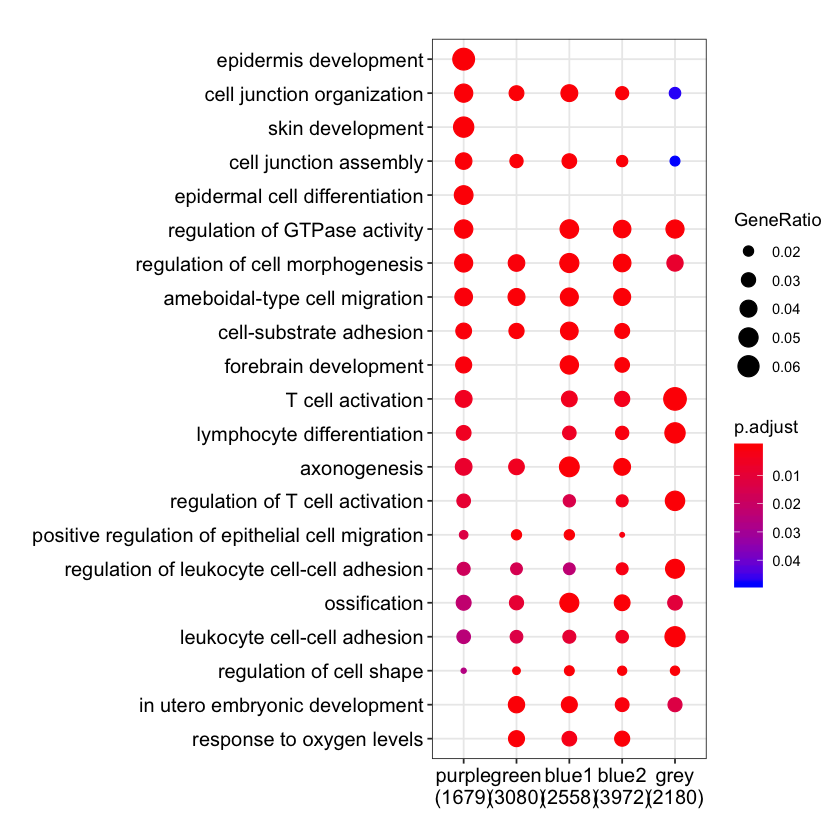

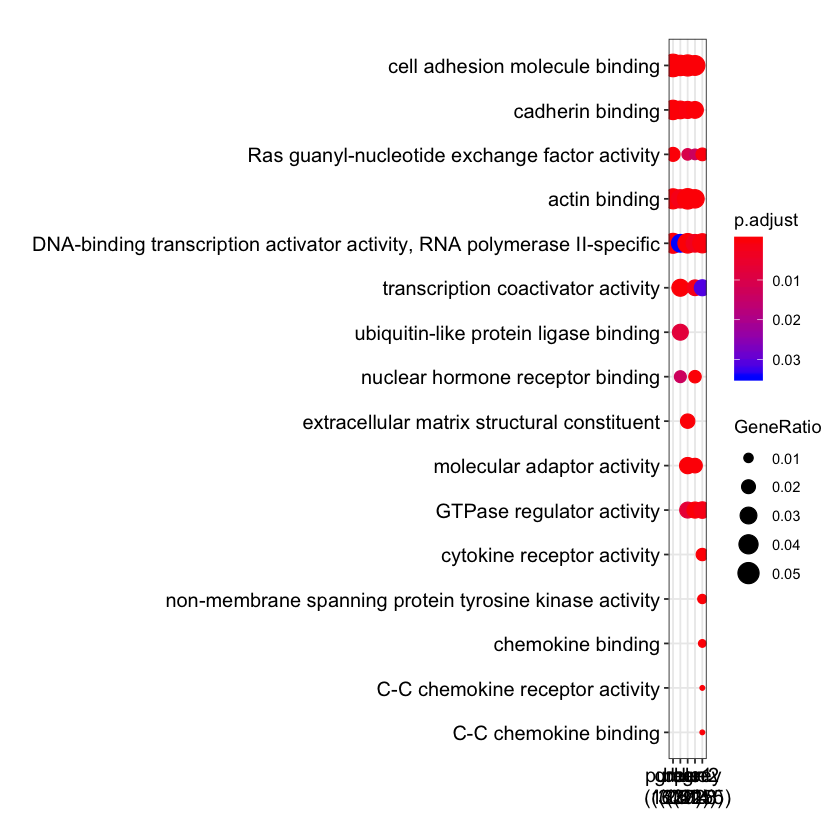

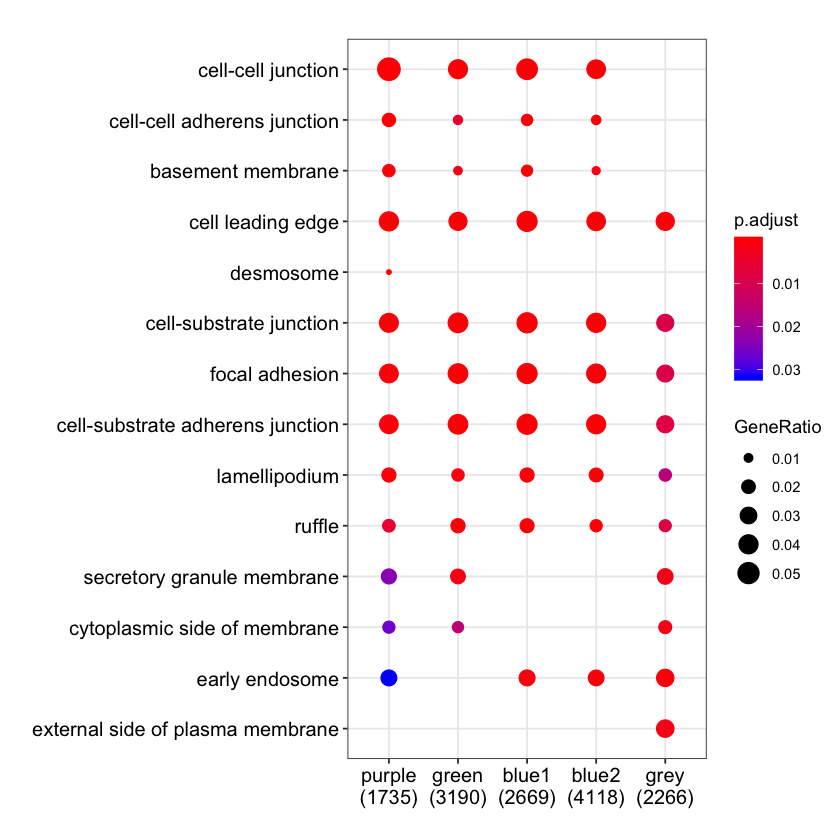

In [36]:
dotplot(ck_go_bp)
ggsave(file = paste0(save_prefix, "ck_go_bp_groups.pdf"),height=7, width=10)
dotplot(ck_go_mf)
ggsave(file = paste0(save_prefix, "ck_go_mf_groups.pdf"),height=7, width=10)
dotplot(ck_go_cc)
ggsave(file = paste0(save_prefix, "ck_go_cc_groups.pdf"),height=7, width=10)

# manual edit

manually edit `ck_go_bp_05.csv` and then reload

for selected go terms

In [172]:
go_terms_sel = read.csv(paste0(save_prefix,'ck_go_bp_terms_sel.txt'),header=F,stringsAsFactor=F)$V1
length(go_terms_sel)

[1] 39

In [173]:
unique(data.frame(ck_go_bp_sel)$Cluster)

[1] purple green  blue1  blue2  grey  
Levels: grey blue1 blue2 green purple

In [174]:

green_only_terms = data.frame(ck_go_bp)%>%
    group_by(Description)%>%
    summarise(n=n())%>%
    filter(n==1)%>%
    left_join(ck_go_bp, by='Description')%>%
    filter(Cluster=='green')%>%
    filter(p.adjust	<0.01)%>%
    arrange(p.adjust)
green_only_terms$Description
# write.csv(green_only_terms,paste0(save_prefix, 'green_only_terms.csv'))

[1] positive regulation of cell cycle                                                           
 [2] modification of morphology or physiology of other organism involved in symbiotic interaction
 [3] coenzyme biosynthetic process                                                               
 [4] modification by symbiont of host morphology or physiology                                   
 [5] proteasomal protein catabolic process                                                       
 [6] transcription initiation from RNA polymerase II promoter                                    
 [7] regulation of mRNA metabolic process                                                        
 [8] DNA-templated transcription, initiation                                                     
 [9] DNA damage response, signal transduction by p53 class mediator                              
[10] response to topologically incorrect protein                                                 
[11] hepatocyte apoptotic process                                                                
[12] signal transduction in response to DNA damage                                               
[13] regulation of transcription from RNA polymerase II promoter in response to stress           
[14] regulation of transcription from RNA polymerase II promoter in response to hypoxia          
[15] RNA splicing                                                                                
[16] positive regulation of cellular amide metabolic process                                     
[17] regulation of DNA-templated transcription in response to stress                             
[18] regulation of extrinsic apoptotic signaling pathway via death domain receptors              
[19] mitotic nuclear division                                                                    
[20] platelet degranulation                                                                      
[21] maintenance of gastrointestinal epithelium                                                  
[22] protein modification by small protein removal                                               
[23] regulation of cellular amide metabolic process                                              
[24] cofactor biosynthetic process                                                               
[25] regulation of cell cycle G1/S phase transition                                              
[26] cellular response to topologically incorrect protein                                        
[27] response to unfolded protein                                                                
[28] positive regulation of mitotic cell cycle                                                   
[29] modulation by virus of host morphology or physiology                                        
[30] epithelial structure maintenance                                                            
[31] modulation by symbiont of host cellular process                                             
[32] establishment of protein localization to membrane                                           
[33] protein deubiquitination                                                                    
[34] regulation of G1/S transition of mitotic cell cycle                                         
[35] nerve development                                                                           
[36] purine nucleotide biosynthetic process                                                      
[37] DNA biosynthetic process                                                                    
[38] establishment of endothelial barrier                                                        
[39] purine-containing compound biosynthetic process                                             
[40] nuclear-transcribed mRNA catabolic process, deadenylation-dependent decay                   
[41] purine ribonucleotide biosynthetic process                                  

In [215]:
ck_go_bp = read.csv(paste0(save_prefix,'ck_go_bp_05.csv'),row.names=1)
ck_go_bp_sel = data.frame(ck_go_bp)
dim(ck_go_bp_sel)
ck_go_bp_sel = ck_go_bp_sel%>%
    mutate(Cluster = factor(Cluster,levels=c('grey','blue1','blue2','green','purple')))%>%
#     mutate(Cluster = factor(Cluster,levels=c('grey','blue1','blue2','green','purple')))%>%
    filter(Description %in% go_terms_sel)%>%
    filter(p.adjust	<0.01)
ck_go_bp_sel_df = ck_go_bp_sel
head(ck_go_bp_sel)
dim(ck_go_bp_sel)
ck_go_bp_sel <- new("compareClusterResult",
               compareClusterResult = ck_go_bp_sel,
               geneClusters = cluster_all,
               .call = match.call(expand.dots=TRUE)
               )
ck_go_bp_sel@compareClusterResult =  ck_go_bp_sel@compareClusterResult%>%
    mutate(Description=factor(Description, levels=go_terms_sel))

ck_go_bp_sel@fun <- 'enrichGO'


[1] 4258   10

,Cluster,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<int>
1,purple,GO:0008544,epidermis development,107/1679,464/18670,2.914973e-20,1.753939e-16,1.390596e-16,ABCA12/ANXA1/ATP2A2/BCL2/CALML5/CD109/CDH3/CELSR1/COL17A1/COL7A1/CSTA/CTNNB1/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FGFR2/FOSL2/FOXC1/FST/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KRT14/KRT15/KRT16/KRT20/KRT23/KRT31/KRT32/KRT33A/KRT34/KRT37/KRT39/KRT5/KRT6A/KRT74/KRT78/KRT8/KRT80/KRT83/KRT84/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP29-1/KRTAP3-2/KRTAP4-6/KRTAP4-8/LAMA3/LAMB3/LAMC2/LCE5A/LELP1/LGR4/MYSM1/NAB2/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PITX2/PKP1/POU2F3/PPARD/PRKCH/PTHLH/RBP2/RPTN/RUNX1/SATB1/SERPINB13/SOS1/SOX9/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TMC1/TNFRSF19/TP63/TRIOBP/UGCG/YAP1/ZFP36L1/ZNF750,107
2,purple,GO:0043588,skin development,93/1679,419/18670,1.279040e-16,2.565327e-13,2.033897e-13,ABCA12/ANXA1/BCL2/CD109/CDH3/CELSR1/CLDN1/CLDN4/CSTA/CTNNB1/CTSV/DKK1/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EGFR/EREG/ERRFI1/EXPH5/FGFR2/FOSL2/FOXC1/FST/GJB3/GRHL1/GRHL2/GRHL3/HRNR/INHBA/IRF6/ITGA2/ITGA6/IVL/JAG1/JUP/KAZN/KRT14/KRT15/KRT16/KRT20/KRT23/KRT31/KRT32/KRT33A/KRT34/KRT37/KRT39/KRT5/KRT6A/KRT74/KRT78/KRT8/KRT80/KRT83/KRT84/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP29-1/KRTAP3-2/KRTAP4-6/KRTAP4-8/LCE5A/LELP1/LGR4/MET/MYSM1/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SOS1/SOX9/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/STMN1/TNFRSF19/TP63/UGCG/YAP1/ZFP36L1,93
3,purple,GO:0009913,epidermal cell differentiation,80/1679,358/18670,1.215253e-14,1.391167e-11,1.102975e-11,ABCA12/ANXA1/CD109/CDH3/CSTA/CTNNB1/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/FOXC1/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KEAP1/KLF4/KLF7/KRT14/KRT15/KRT16/KRT20/KRT23/KRT31/KRT32/KRT33A/KRT34/KRT37/KRT39/KRT5/KRT6A/KRT74/KRT78/KRT8/KRT80/KRT83/KRT84/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP29-1/KRTAP3-2/KRTAP4-6/KRTAP4-8/LCE5A/LELP1/NOTCH1/NUMA1/PAFAH1B1/PALLD/PERP/PITX2/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TMC1/TP63/TRIOBP/UGCG/YAP1/ZFP36L1,80
4,purple,GO:0030216,keratinocyte differentiation,72/1679,305/18670,1.387236e-14,1.391167e-11,1.102975e-11,ABCA12/ANXA1/CD109/CDH3/CSTA/CTSV/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/EREG/ERRFI1/EXPH5/FOSL2/FOXC1/GRHL1/GRHL2/HRNR/IRF6/IVL/JAG1/JUP/KAZN/KRT14/KRT15/KRT16/KRT20/KRT23/KRT31/KRT32/KRT33A/KRT34/KRT37/KRT39/KRT5/KRT6A/KRT74/KRT78/KRT8/KRT80/KRT83/KRT84/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP29-1/KRTAP3-2/KRTAP4-6/KRTAP4-8/LCE5A/LELP1/NOTCH1/NUMA1/PALLD/PERP/PKP1/PRKCH/RPTN/RUNX1/SERPINB13/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G/TP63/UGCG/YAP1/ZFP36L1,72
5,purple,GO:0070268,cornification,38/1679,112/18670,1.808804e-13,1.554797e-10,1.232707e-10,CSTA/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/IVL/JUP/KAZN/KRT14/KRT15/KRT16/KRT20/KRT23/KRT31/KRT32/KRT33A/KRT34/KRT37/KRT39/KRT5/KRT6A/KRT74/KRT78/KRT8/KRT80/KRT83/KRT84/PERP/PKP1/RPTN/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G,38
6,purple,GO:0031424,keratinization,49/1679,224/18670,3.591027e-09,2.160721e-06,1.713109e-06,ABCA12/CDH3/CSTA/DSC1/DSC2/DSC3/DSG1/DSG2/DSG3/DSP/HRNR/IVL/JUP/KAZN/KRT14/KRT15/KRT16/KRT20/KRT23/KRT31/KRT32/KRT33A/KRT34/KRT37/KRT39/KRT5/KRT6A/KRT74/KRT78/KRT8/KRT80/KRT83/KRT84/KRTAP16-1/KRTAP17-1/KRTAP2-3/KRTAP29-1/KRTAP3-2/KRTAP4-6/KRTAP4-8/LCE5A/PERP/PKP1/RPTN/SPINK6/SPINK9/SPRR2D/SPRR2F/SPRR2G,49


[1] 69 10

In [209]:
data.frame(ck_go_bp_sel)%>%
    group_by(Description)%>%
    summarise(count=n())%>%
    dim()

[1] 39  2

In [210]:
# ck_go_bp_sel@compareClusterResult$Description
data.frame(ck_go_bp_sel)$Description

[1] epidermis development                                    
 [2] skin development                                         
 [3] epidermal cell differentiation                           
 [4] keratinocyte differentiation                             
 [5] cornification                                            
 [6] keratinization                                           
 [7] gland development                                        
 [8] regulation of actin filament-based process               
 [9] regulation of actin cytoskeleton organization            
[10] morphogenesis of a branching epithelium                  
[11] epithelium migration                                     
[12] epithelial cell migration                                
[13] positive regulation of epithelial cell migration         
[14] epithelial tube morphogenesis                            
[15] epithelium migration                                     
[16] gland development                                        
[17] regulation of cellular response to growth factor stimulus
[18] epithelial cell migration                                
[19] response to transforming growth factor beta              
[20] I-kappaB kinase/NF-kappaB signaling                      
[21] morphogenesis of a branching epithelium                  
[22] regulation of actin cytoskeleton organization            
[23] regulation of actin filament-based process               
[24] maintenance of gastrointestinal epithelium               
[25] epithelial structure maintenance                         
[26] actomyosin structure organization                        
[27] epithelial cell morphogenesis                            
[28] regulation of actin filament-based process               
[29] response to transforming growth factor beta              
[30] regulation of actin cytoskeleton organization            
[31] epithelial tube morphogenesis                            
[32] gland development                                        
[33] regulation of cellular response to growth factor stimulus
[34] epithelium migration                                     
[35] epithelial cell migration                                
[36] actomyosin structure organization                        
[37] morphogenesis of a branching epithelium                  
[38] positive regulation of epithelial cell migration         
[39] neural precursor cell proliferation                      
[40] synapse organization                                     
[41] regulation of membrane repolarization                    
[42] regulation of ion transmembrane transporter activity     
[43] forebrain neuron differentiation                         
[44] regulation of cation channel activity                    
[45] action potential                                         
[46] central nervous system projection neuron axonogenesis    
[47] response to transforming growth factor beta              
[48] epithelial cell migration                                
[49] epithelium migration                                     
[50] actomyosin structure organization                        
[51] regulation of actin filament-based process               
[52] gland development                                        
[53] vesicle organization                                     
[54] regulation of actin cytoskeleton organization            
[55] pigmentation                                             
[56] epithelial tube morphogenesis                            
[57] melanocyte differentiation                               
[58] developmental pigmentation                               
[59] regulation of cellular response to growth factor stimulus
[60] positive regulation of epithelial cell migration         
[61] morphogenesis of a branching epithelium                  
[62] neural precursor cell proliferation                      
[63] melanin metabolic process                                
[64] pigment cell differentiatio

In [213]:
ck_go_bp_sel

#
# Result of Comparing 5 gene clusters 
#
#.. @fun 	 enrichGO 
#.. @geneClusters 	List of 5
 $ purple: chr [1:2117] "22848" "60496" "26154" "4363" ...
 $ green : chr [1:3793] "144568" "14" "132949" "19" ...
 $ blue1 : chr [1:3346] "127550" "19" "154664" "24" ...
 $ blue2 : chr [1:4975] "127550" "53947" "79719" "60496" ...
 $ grey  : chr [1:2695] "53947" "8086" "284837" "26154" ...
#...Result 	'data.frame':	69 obs. of  10 variables:
 $ Cluster    : Factor w/ 5 levels "grey","blue1",..: 5 5 5 5 5 5 5 5 5 5 ...
 $ ID         : Factor w/ 2276 levels "GO:0000070","GO:0000082",..: 399 1174 447 688 1773 774 1416 882 876 1733 ...
 $ Description: Factor w/ 39 levels "lymphocyte proliferation",..: 33 34 35 36 37 38 39 13 15 30 ...
 $ GeneRatio  : Factor w/ 546 levels "10/1679","10/2180",..: 27 520 465 422 243 298 432 395 346 233 ...
 $ BgRatio    : Factor w/ 421 levels "10/18670","100/18670",..: 343 310 262 213 15 135 322 288 250 92 ...
 $ pvalue     : num  2.91e-20 1.28e-16 1.22e-14 1.39e-14 1

In [212]:
# ggplot(ck_go_bp_sel_df, aes(x=Cluster, y=Description, color=p.adjust,size=GeneRatio))+geom_point()+theme_classic()

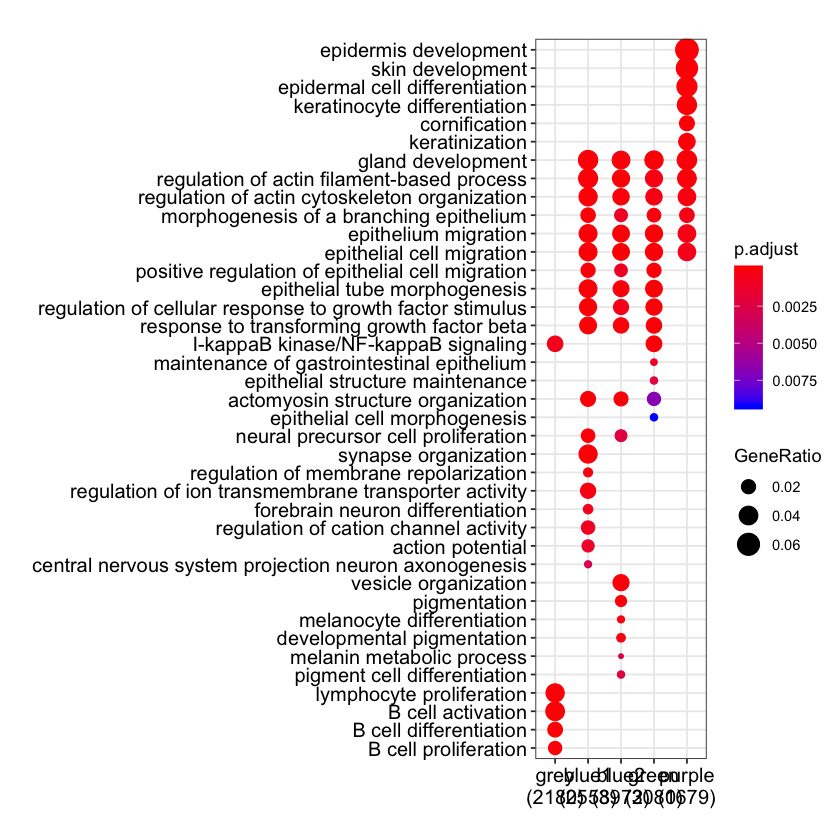

In [211]:
dotplot(ck_go_bp_sel,showCategory = 40)
ggsave(file = paste0(save_prefix, "ck_go_bp_groups_sel.eps"),height=8, width=8)